# Signal/Background Classification using Boosted Decision Trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score
import helper_function_module_BDT as hfm
from tqdm import tqdm
import os
from sklearn.inspection import permutation_importance

SEED = 73529
np.random.seed(SEED)

In [2]:
import os
print(os.getcwd())

/teamspace/studios/this_studio/all/BDT/minpt20


## 1. Data Loading

In [5]:
signal = hfm.load_json_data("/teamspace/studios/this_studio/all/txt_data_preprocess/onlyAny2bj_onlyAny1p/ppzaxbba_ax45_200k_minpt20_15jets_etafiltered_corrected_onlyAny2j_onlyAny1p_processed.json")
background = hfm.load_json_data("/teamspace/studios/this_studio/all/txt_data_preprocess/onlyAny2bj_onlyAny1p/background_ppbba_500k_minpt20_15jets_etafiltered_corrected_onlyAny2j_onlyAny1p_processed.json")

Loading event data from /teamspace/studios/this_studio/all/txt_data_preprocess/onlyAny2bj_onlyAny1p/ppzaxbba_ax45_200k_minpt20_15jets_etafiltered_corrected_onlyAny2j_onlyAny1p_processed.json...
--- Successfully loaded 1617 events :)
Loading event data from /teamspace/studios/this_studio/all/txt_data_preprocess/onlyAny2bj_onlyAny1p/background_ppbba_500k_minpt20_15jets_etafiltered_corrected_onlyAny2j_onlyAny1p_processed.json...
--- Successfully loaded 1893 events :)


In [6]:
signal[23]

{'eventno': 2777,
 'jets': [{'jet_index': 1,
   'Eta': -0.67095,
   'Phi': 1.43795,
   'pT': 31.2229,
   'Px': 4.13581,
   'Py': 30.9478,
   'Pz': -22.5565,
   'E': 38.5184,
   'btag': 1},
  {'jet_index': 2,
   'Eta': -0.573299,
   'Phi': 0.916917,
   'pT': 26.2736,
   'Px': 15.9815,
   'Py': 20.8542,
   'Pz': -15.9014,
   'E': 30.7109,
   'btag': 1},
  {'jet_index': 3,
   'Eta': 0.558182,
   'Phi': -1.82506,
   'pT': 25.9828,
   'Px': -6.53556,
   'Py': -25.1474,
   'Pz': 15.268,
   'E': 30.1367,
   'btag': 0}],
 'photons': [{'isophoton_index': 1,
   'Eta': -0.35754,
   'Phi': -1.57356,
   'pT': 31.4033,
   'Px': -0.0867958,
   'Py': -31.4032,
   'Pz': -11.4687,
   'E': 33.432}],
 'num_btag_jets': 2,
 'num_isophoton': 1}

In [7]:
signal_df= hfm.prepare_data_for_model(signal, required_jets=2, required_photons=1, event_label = 1)

if signal_df is not None:
    print("\n--- Data Shapes Before Splitting ---")
    print(f"Signal DF shape: {signal_df.shape}")

background_df= hfm.prepare_data_for_model(background, required_jets=2, required_photons=1, event_label = 0)

if background_df is not None:
    print("\n--- Data Shapes Before Splitting ---")
    print(f"Background DF shape: {background_df.shape}")

Processing 1617 events to extract features...


Extracting Features: 100%|██████████| 1617/1617 [00:00<00:00, 9350.23it/s]



--- Data Shapes Before Splitting ---
Signal DF shape: (1617, 5)
Processing 1893 events to extract features...


Extracting Features: 100%|██████████| 1893/1893 [00:00<00:00, 8617.05it/s]


--- Data Shapes Before Splitting ---
Background DF shape: (1893, 5)


In [8]:
signal_df.head()

,isophoton_pT,deltaR_jet12,invMass_2j1p,inv_mass_2j,event_label
228,37.8202,1.528268,90.217726,35.749479,1
436,33.6836,1.864275,86.379330,41.784548,1
438,12.9447,1.233783,92.799513,44.989771,1
448,57.5455,3.321406,314.575115,245.827460,1
541,36.5321,1.902607,104.956134,53.957922,1


In [9]:
background_df.head()

,isophoton_pT,deltaR_jet12,invMass_2j1p,inv_mass_2j,event_label
541,20.8574,0.541099,61.967540,17.724672,0
1087,12.3144,3.163884,149.021284,135.646229,0
1619,18.6661,3.769648,161.401193,137.281558,0
2298,10.3313,3.497819,108.507152,98.248791,0
2751,15.6680,3.123787,155.639812,135.456430,0


In [10]:
data = pd.concat([signal_df, background_df], axis = 0)

In [11]:
data = data.sample(frac=1, random_state = SEED)
data.head()

,isophoton_pT,deltaR_jet12,invMass_2j1p,inv_mass_2j,event_label
4153,32.4842,2.187702,108.015399,61.379319,1
67497,14.4962,3.196085,148.911293,115.769986,1
101997,35.3818,2.908459,161.953227,109.435226,1
300508,58.2025,1.268016,168.000777,45.521808,0
209296,19.9313,3.992391,183.425637,143.429900,0


In [12]:
X, y = data.iloc[:,:-1].values, data.loc[:,'event_label'].values.astype(int)

In [13]:
X.shape

(3510, 4)

## 2. Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=SEED,
                                                   stratify = y)

print("\n--- Data Shapes After Splitting ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


--- Data Shapes After Splitting ---
X_train shape: (2457, 4)
X_test shape: (1053, 4)
y_train shape: (2457,)
y_test shape: (1053,)


# Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
param_grid_forest = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20]
}
grid_search_forest = GridSearchCV(RandomForestClassifier(random_state=SEED),
                          param_grid=param_grid_forest,
                          cv=5,
                          n_jobs=-1)

In [17]:
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=73529),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200, 300, 500]})

Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100}


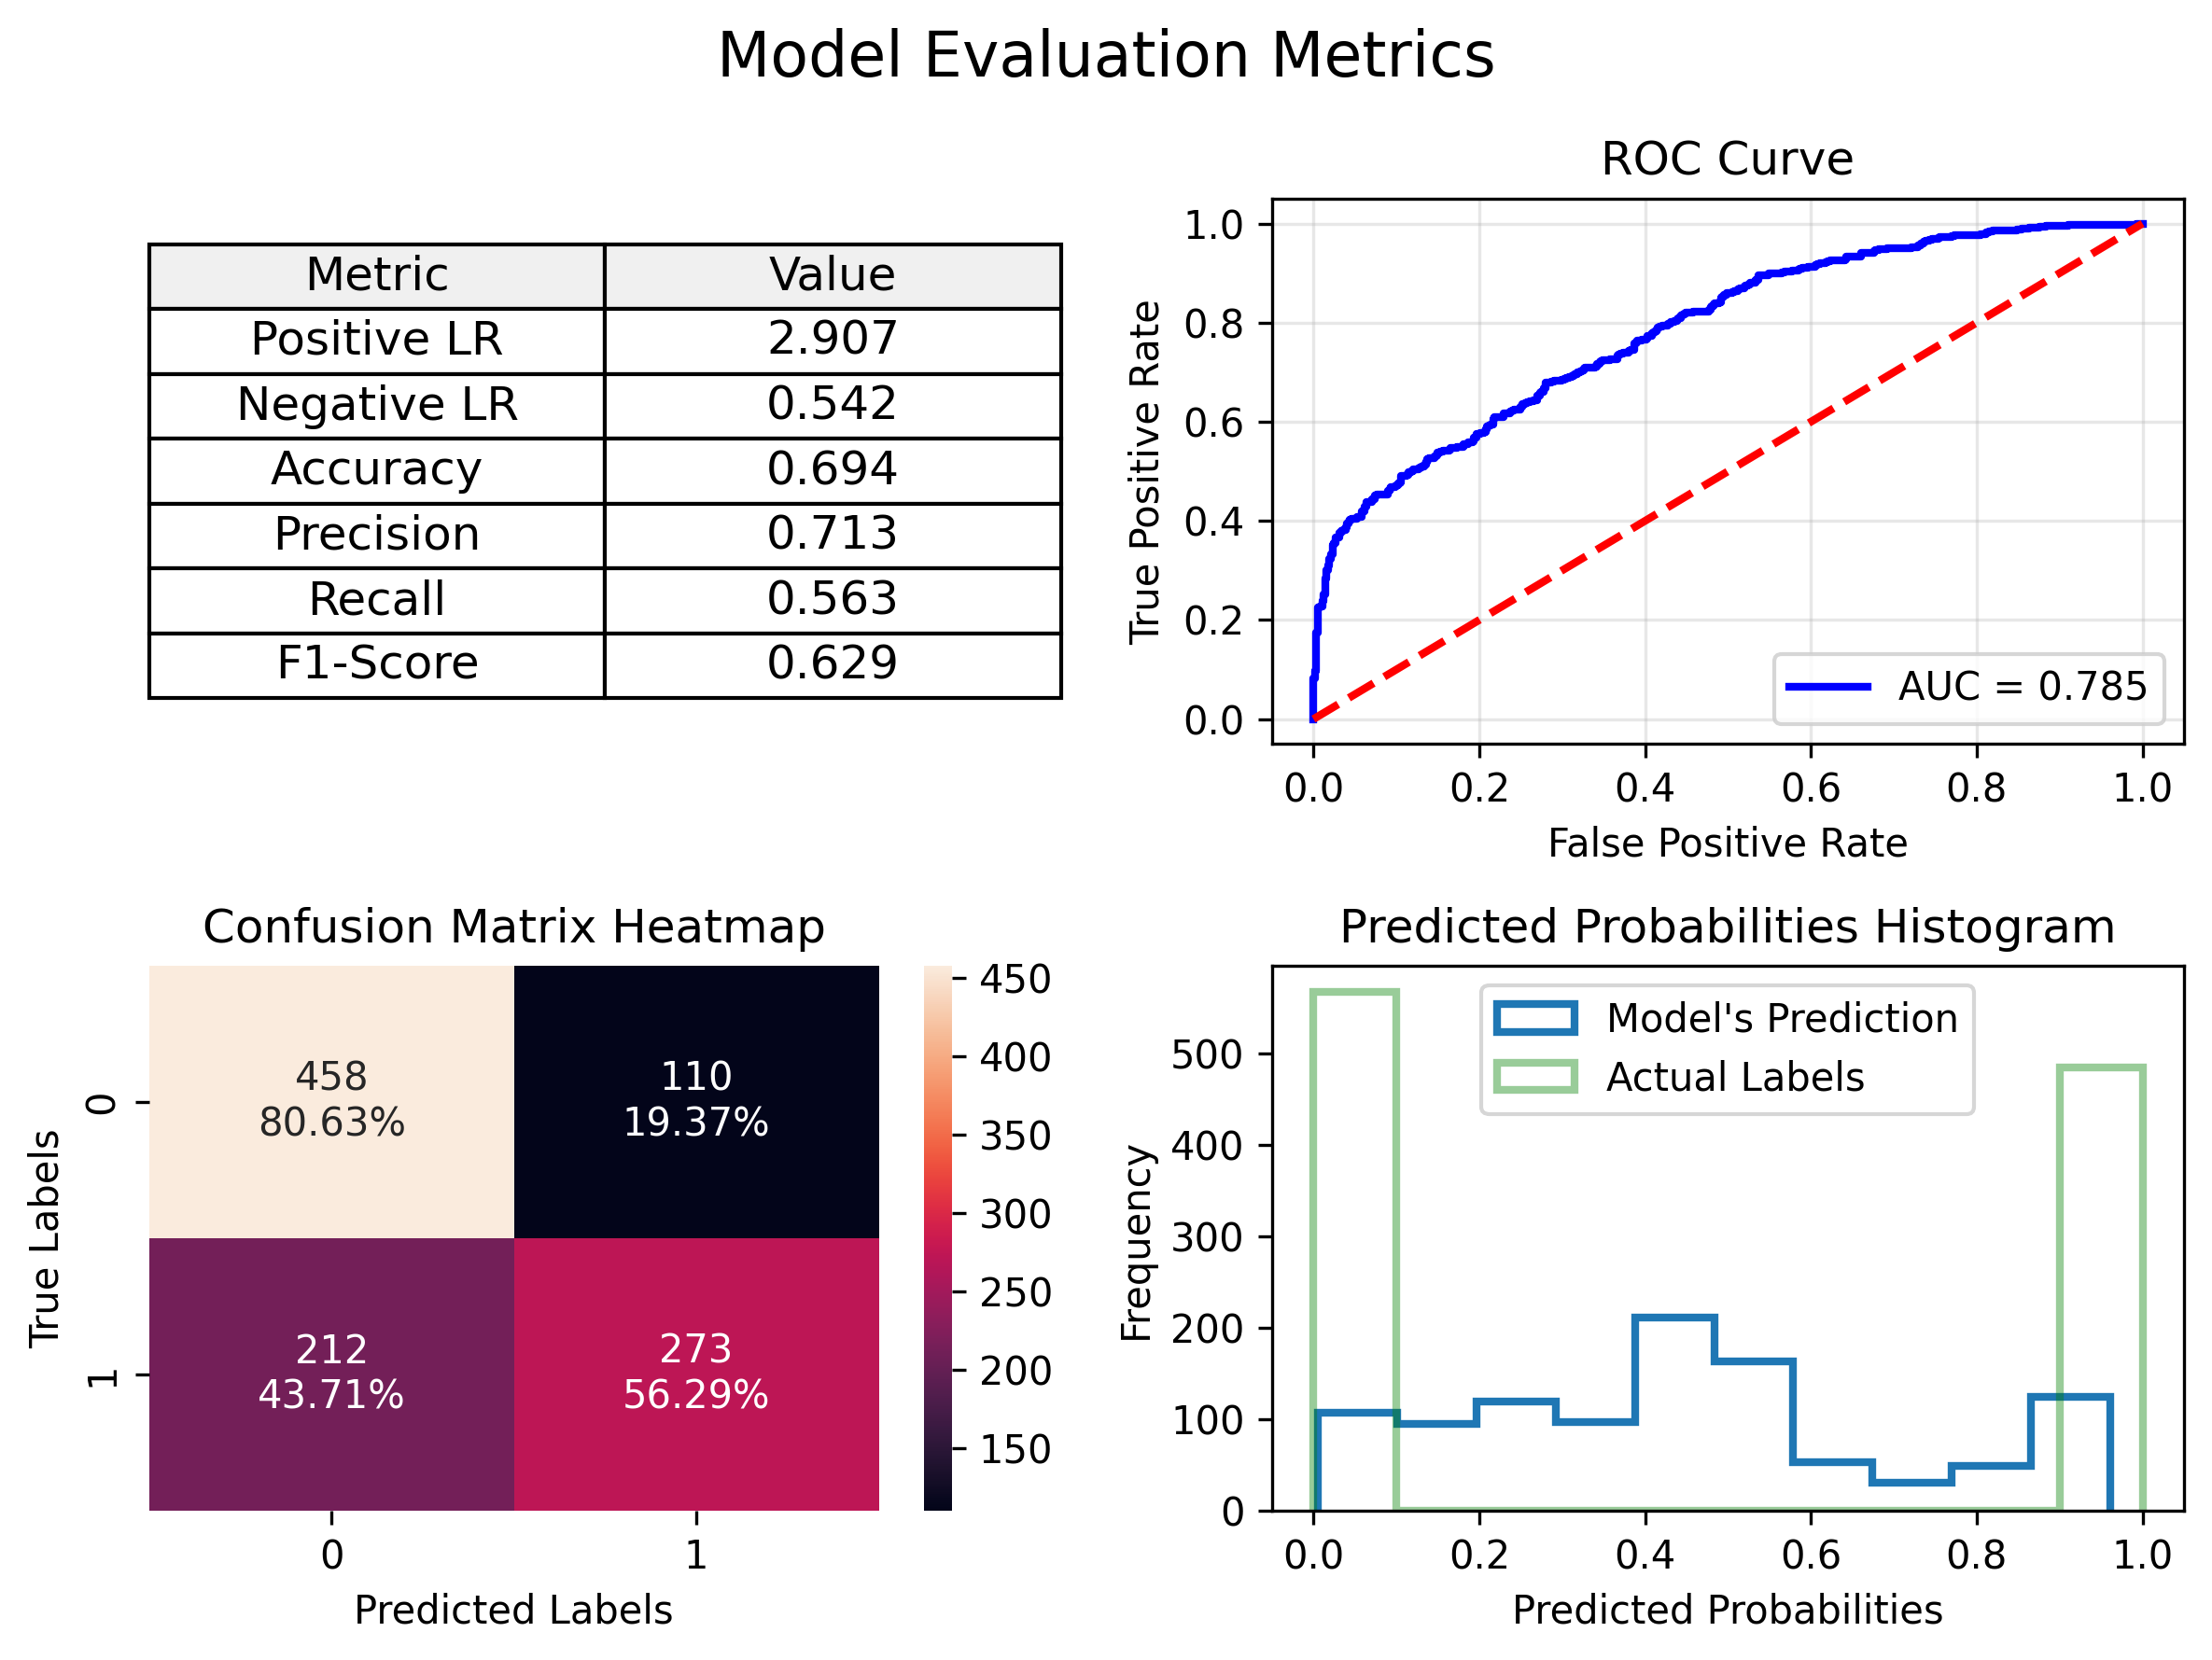

In [18]:
best_model_rf = grid_search_forest.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
y_pred_prob_rf = best_model_rf.predict_proba(X_test)[:, 1] #For getting probabilites of class label 1

print(f'Best Hyperparameters: {grid_search_forest.best_params_}')

y_pred_label_rf = [1 if (y_prob >= 0.5) else 0 for y_prob in y_pred_prob_rf]
hfm.eval_model(y_test, y_pred_prob_rf, y_pred_label_rf, save_fig = False, save_fig_path = 'ax45_RFEval_Metrics.png')

# Gradient Boosting Classifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
param_grid_grad = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.001]
}

In [21]:
grid_search_grad = GridSearchCV(GradientBoostingClassifier(random_state=SEED),
                          param_grid=param_grid_grad,
                          cv=5,
                          n_jobs=-1)

In [22]:
grid_search_grad.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=73529),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.001],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]})

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


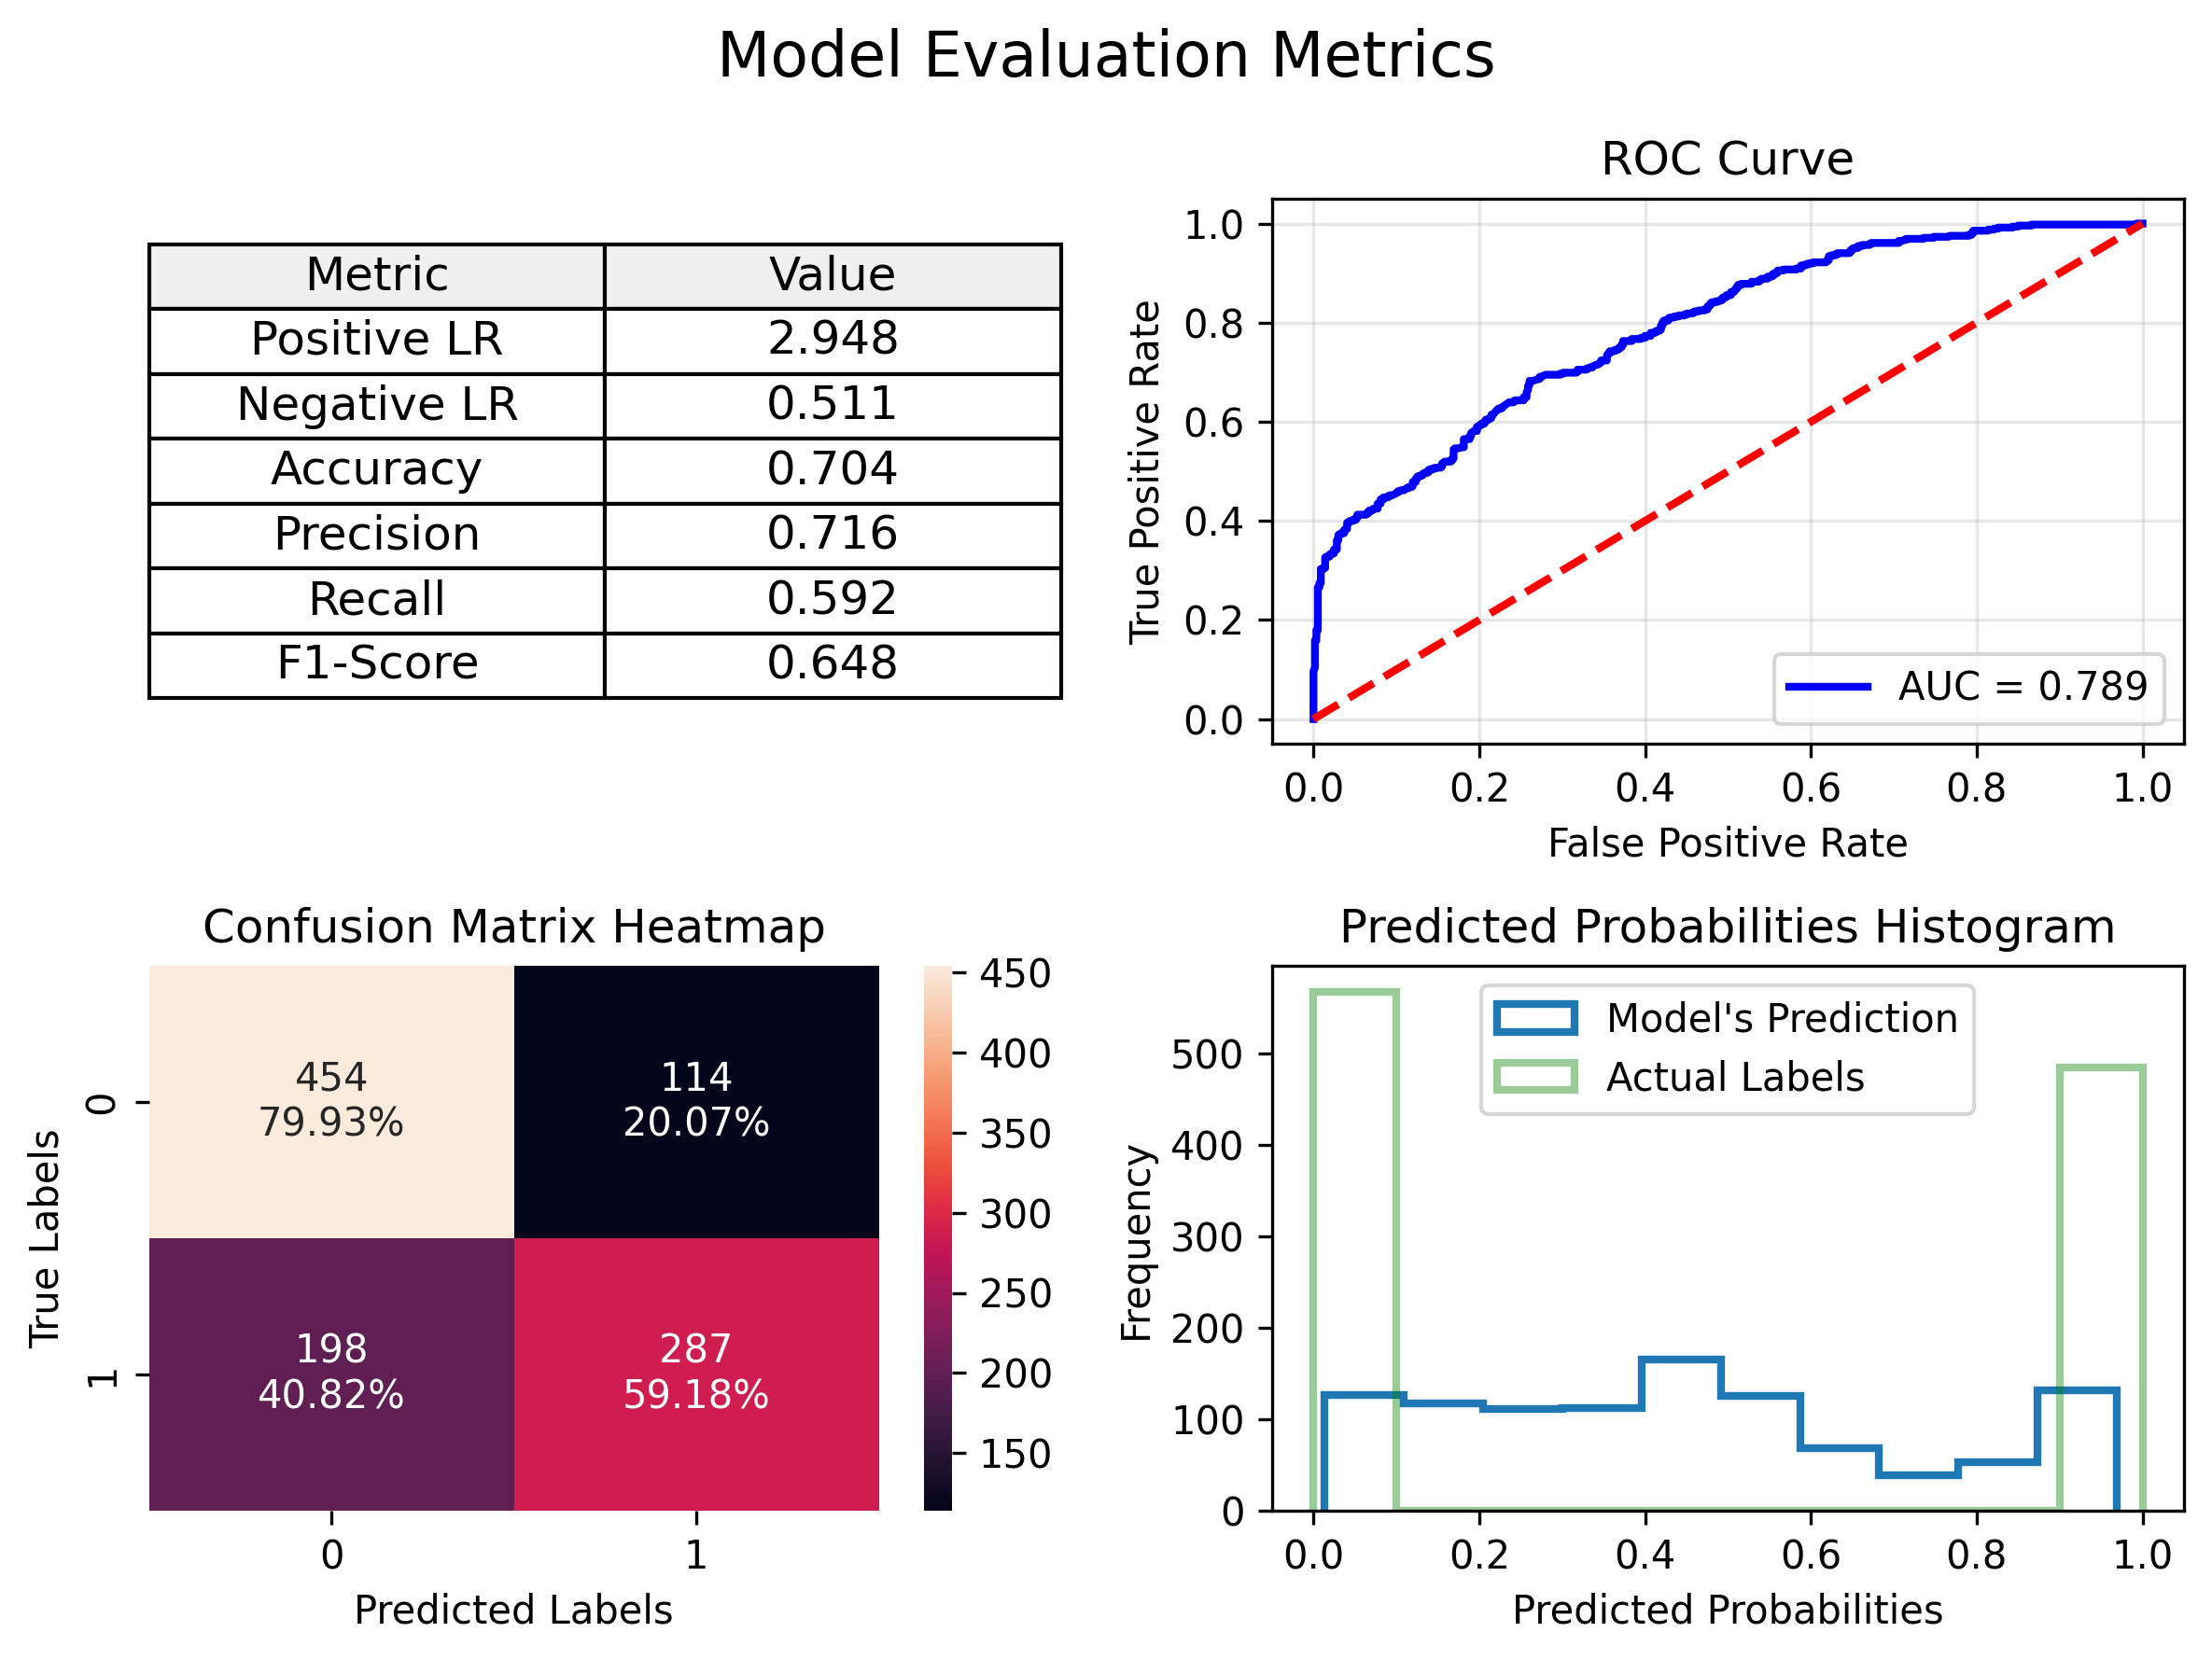

In [23]:
best_model_gb = grid_search_grad.best_estimator_
y_pred_gb = best_model_gb.predict(X_test)
y_pred_prob_gb = best_model_gb.predict_proba(X_test)[:, 1] #For getting probabilites of class label 1

print(f'Best Hyperparameters: {grid_search_grad.best_params_}')

y_pred_label_gb = [1 if (y_prob >= 0.5) else 0 for y_prob in y_pred_prob_gb]
hfm.eval_model(y_test, y_pred_prob_gb, y_pred_label_gb, save_fig = False, save_fig_path = 'ax45_GBEval_Metrics.png')

# Extracting Feature Importances - RandomForest

In [24]:
features_col = data.columns[:-1]


--- Calculating Impurity-Based Feature Importance (MDI) ---
inv_mass_2j     0.262899
isophoton_pT    0.261387
invMass_2j1p    0.245674
deltaR_jet12    0.230040
dtype: float64


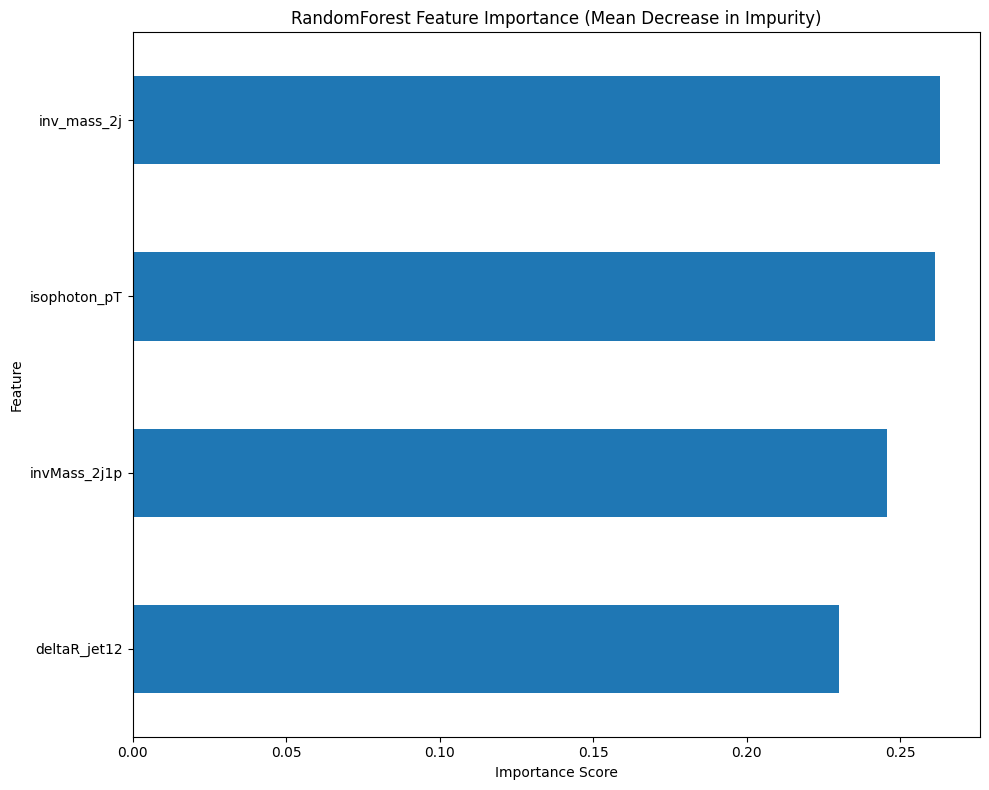

In [25]:
print("\n--- Calculating Impurity-Based Feature Importance (MDI) ---")
# Get importance scores directly from the trained model
rf_importances_mdi = best_model_rf.feature_importances_

# Create a Pandas Series for easy handling and sorting
rf_importances_mdi = pd.Series(rf_importances_mdi, index=features_col)
rf_importances_mdi = rf_importances_mdi.sort_values(ascending=False)

print(rf_importances_mdi)

# --- Visualize MDI Importances ---
plt.figure(figsize=(10, 8))
rf_importances_mdi.plot(kind='barh')
plt.title("RandomForest Feature Importance (Mean Decrease in Impurity)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

## Permutation Importance - RandomForest


--- Calculating Permutation Importance (on Test Set) ---

Features Permutation Importance on Test Set, metric='roc_auc'):
invMass_2j1p    0.127538
isophoton_pT    0.073339
deltaR_jet12    0.059657
inv_mass_2j     0.041384
dtype: float64


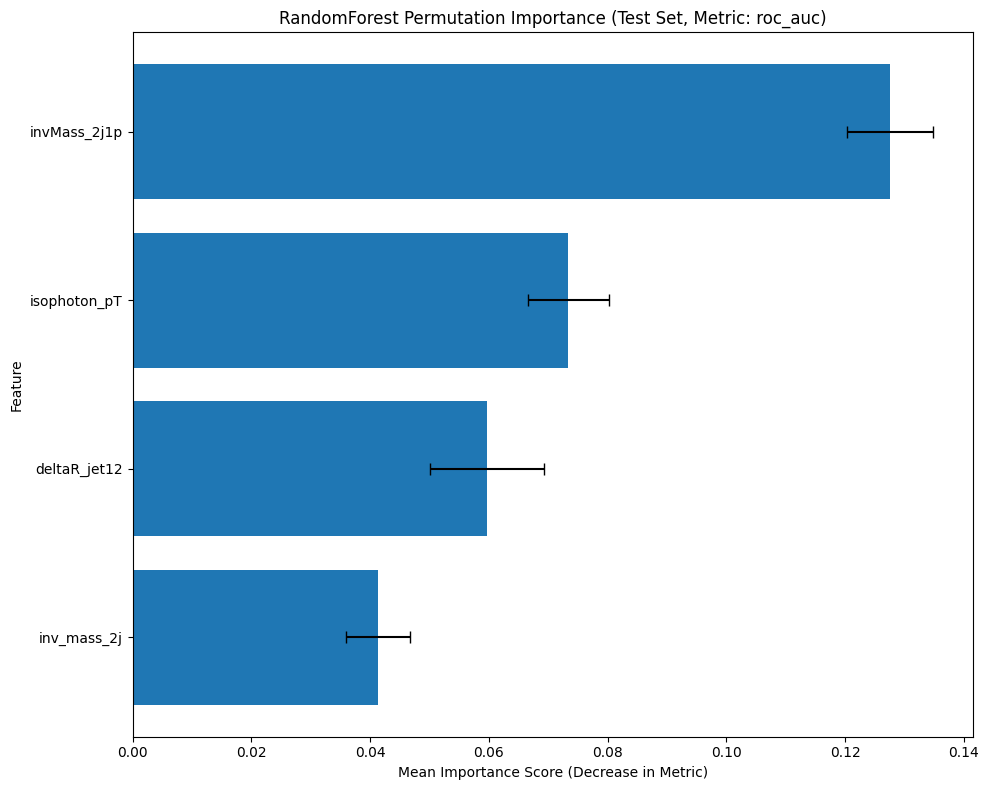

In [26]:
print("\n--- Calculating Permutation Importance (on Test Set) ---")


# Choose a scoring metric - accuracy, roc_auc, f1, balanced_accuracy etc.
# For imbalanced data, 'roc_auc', 'f1_weighted', or 'balanced_accuracy' are often better than 'accuracy'
scoring_metric = 'roc_auc'

# Calculate permutation importance
# n_repeats: Number of times to shuffle each feature for stability
rf_perm_importance_result = permutation_importance(
    estimator=best_model_rf,
    X=X_test,
    y=y_test,
    scoring=scoring_metric,
    n_repeats=10, # Increase for more stable results, but slower
    random_state=SEED,
    n_jobs=-1 # Use multiple cores if available
)

# Extract mean and standard deviation of importance scores
rf_importances_perm_mean = rf_perm_importance_result.importances_mean
rf_importances_perm_std = rf_perm_importance_result.importances_std

# Create a Pandas Series for easy handling
rf_perm_importances = pd.Series(rf_importances_perm_mean, index=features_col)
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)

print(f"\nFeatures Permutation Importance on Test Set, metric='{scoring_metric}'):")
print(rf_perm_importances)

# --- Visualize Permutation Importances ---
plt.figure(figsize=(10, 8))
# Get sorted indices for plotting std deviations correctly
sorted_idx = rf_perm_importances.index
plt.barh(sorted_idx, rf_perm_importances[sorted_idx],
         xerr=rf_importances_perm_std[rf_perm_importances.index.get_indexer(sorted_idx)], # Map std dev to sorted order
         capsize=4)
plt.title(f"RandomForest Permutation Importance (Test Set, Metric: {scoring_metric})")
plt.xlabel("Mean Importance Score (Decrease in Metric)")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

# Feature Importance - GradientBoost


--- Calculating Impurity-Based Feature Importance (MDI) ---
inv_mass_2j     0.299148
invMass_2j1p    0.290771
isophoton_pT    0.234077
deltaR_jet12    0.176003
dtype: float64


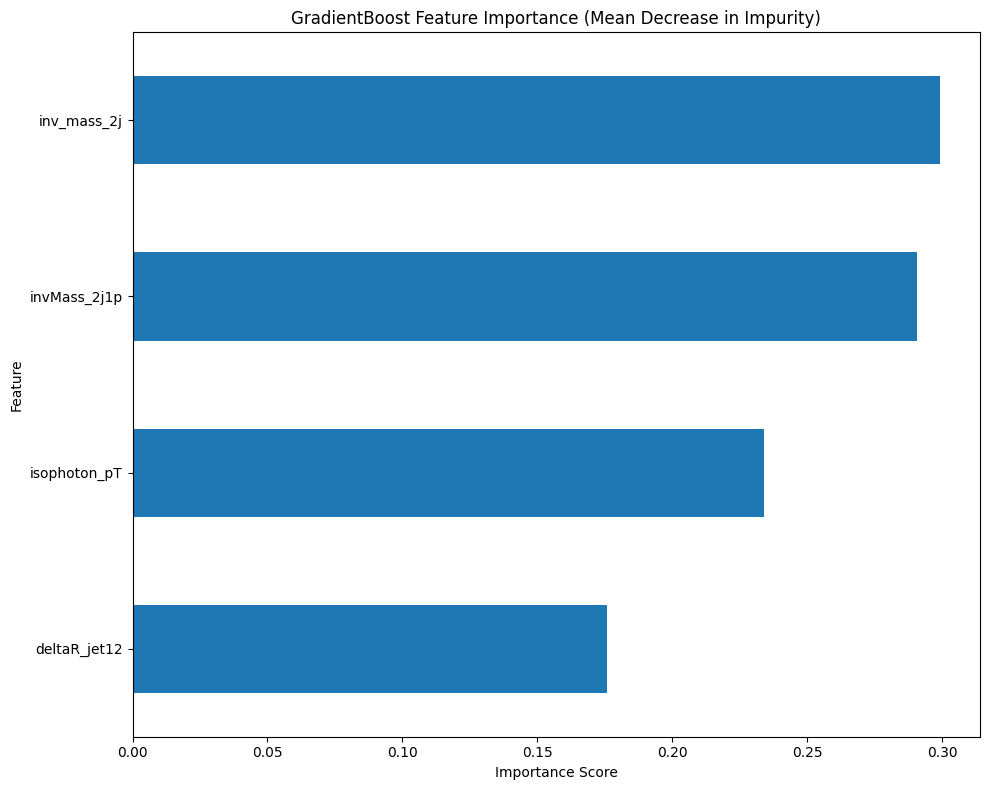

In [27]:
print("\n--- Calculating Impurity-Based Feature Importance (MDI) ---")
# Get importance scores directly from the trained model
gb_importances_mdi = best_model_gb.feature_importances_

# Create a Pandas Series for easy handling and sorting
gb_importances_mdi = pd.Series(gb_importances_mdi, index=features_col)
gb_importances_mdi = gb_importances_mdi.sort_values(ascending=False)

print(gb_importances_mdi)

# --- Visualize MDI Importances ---
plt.figure(figsize=(10, 8))
gb_importances_mdi.plot(kind='barh')
plt.title("GradientBoost Feature Importance (Mean Decrease in Impurity)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

## Permutation Importance - GradientBoost


--- Calculating Permutation Importance (on Test Set) ---

Features Permutation Importance on Test Set, metric='roc_auc'):
invMass_2j1p    0.129589
isophoton_pT    0.071494
inv_mass_2j     0.065960
deltaR_jet12    0.056105
dtype: float64


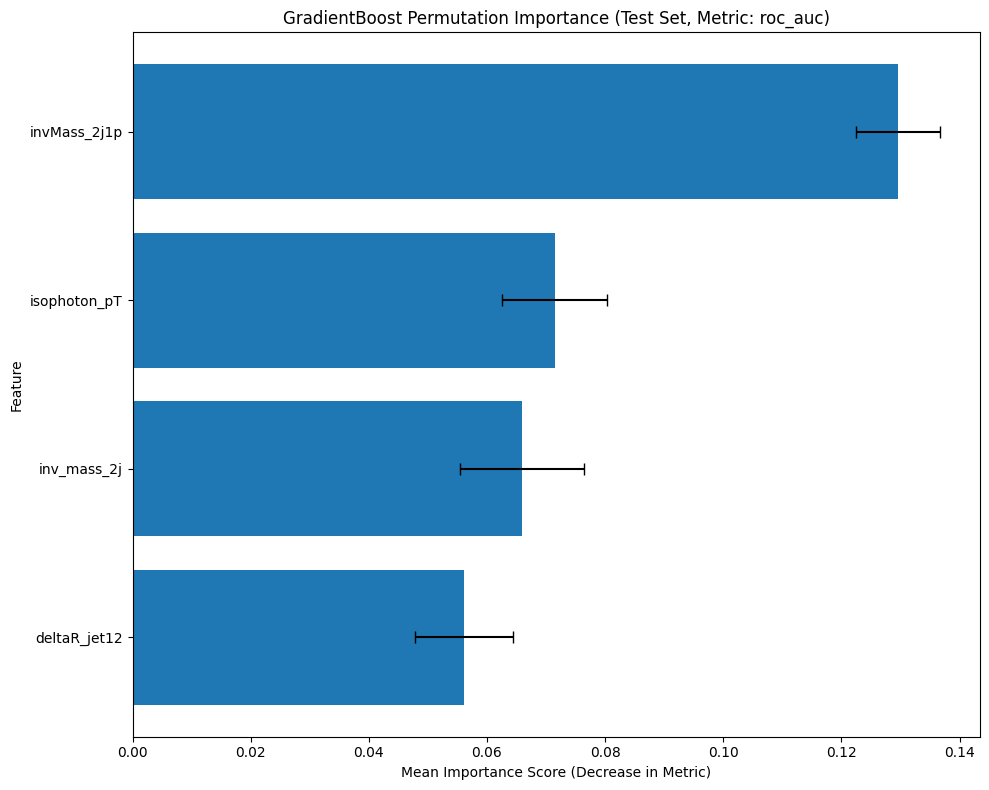

In [29]:
print("\n--- Calculating Permutation Importance (on Test Set) ---")


# Choose a scoring metric - accuracy, roc_auc, f1, balanced_accuracy etc.
# For imbalanced data, 'roc_auc', 'f1_weighted', or 'balanced_accuracy' are often better than 'accuracy'
scoring_metric = 'roc_auc'

# Calculate permutation importance
# n_repeats: Number of times to shuffle each feature for stability
gb_perm_importance_result = permutation_importance(
    estimator=best_model_gb,
    X=X_test,
    y=y_test,
    scoring=scoring_metric,
    n_repeats=10, # Increase for more stable results, but slower
    random_state=SEED,
    n_jobs=-1 # Use multiple cores if available
)

# Extract mean and standard deviation of importance scores
gb_importances_perm_mean = gb_perm_importance_result.importances_mean
gb_importances_perm_std = gb_perm_importance_result.importances_std

# Create a Pandas Series for easy handling
gb_perm_importances = pd.Series(gb_importances_perm_mean, index=features_col)
gb_perm_importances = gb_perm_importances.sort_values(ascending=False)

print(f"\nFeatures Permutation Importance on Test Set, metric='{scoring_metric}'):")
print(gb_perm_importances)

# --- Visualize Permutation Importances ---
plt.figure(figsize=(10, 8))
# Get sorted indices for plotting std deviations correctly
sorted_idx = gb_perm_importances.index
plt.barh(sorted_idx, gb_perm_importances[sorted_idx],
         xerr=gb_importances_perm_std[gb_perm_importances.index.get_indexer(sorted_idx)], # Map std dev to sorted order
         capsize=4)
plt.title(f"GradientBoost Permutation Importance (Test Set, Metric: {scoring_metric})")
plt.xlabel("Mean Importance Score (Decrease in Metric)")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()